<a href="https://colab.research.google.com/github/DanielWarfield1/MLWritingAndResearch/blob/main/LangGraph.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# %pip install --quiet -U langgraph langchain-community langchain-openai
!pip install langgraph langchain-openai

In [2]:
import os
from google.colab import userdata

os.environ['OPENAI_API_KEY'] = userdata.get('OpenAIAPIKey')

# Making a simple graph that runs

In [3]:
from typing import TypedDict
from langgraph.graph import StateGraph, START, END

# Defining state
class GraphState(TypedDict):
    incrementor: int

workflow = StateGraph(GraphState)

# I still have no idea why I need to return the state in this example, and
# I don't in the previous example. But, to me this is more explicit so whatever.
def handle_hello_world(state):
    print('Hello World')
    state['incrementor'] += 1  # Correctly update the state
    return state  # Return the modified state

# Add the node to the graph
workflow.add_node("hello_world", handle_hello_world)

# Set entry point and edge
workflow.set_entry_point("hello_world")
workflow.add_edge('hello_world', END)

# Compile and run the workflow
app = workflow.compile()
inputs = {"incrementor": 0}  # Provide the initial state
result = app.invoke(inputs)
print(result)

Hello World
{'incrementor': 1}


# Making a simple graph that introduces itself, asks for a name, then updates the state

In [4]:
from typing import TypedDict
from langgraph.graph import StateGraph, START, END

# Defining state
class GraphState(TypedDict):
    name: str
    incrementor: int

workflow = StateGraph(GraphState)

# I still have no idea why I need to return the state in this example, and
# I don't in the previous example. But, to me this is more explicit so whatever.
def handle_intro(state):
    state['incrementor'] += 1
    print('Hello!')
    return state  # Does not modify state

def handle_name_request(state):
    state['incrementor'] += 1
    state['name'] = input('What is your name? ')
    return state

# Adding Nodes to Graph
workflow.add_node("intro", handle_intro)
workflow.add_node("name_request", handle_name_request)

# Set entry point and edge
workflow.set_entry_point("intro")
workflow.add_edge('intro', 'name_request')
workflow.add_edge('name_request', END)

# Compile and run the workflow
app = workflow.compile()
inputs = {"incrementor": 0}  # Provide the initial state
result = app.invoke(inputs)
print('output state:')
print(result)

Hello!
What is your name? dan
output state:
{'name': 'dan', 'incrementor': 2}


# Parsing first name and last name

In [5]:
from typing import TypedDict
from langgraph.graph import StateGraph, START, END
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate

# Defining state
class GraphState(TypedDict):
    first_name: str
    last_name: str
    incrementor: int

workflow = StateGraph(GraphState)

def handle_intro(state):
    state['incrementor'] += 1
    print('Hello!')
    return state  # Does not modify state

class Name(TypedDict):
    first_name: str
    last_name: str

name_parse_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            """Parse the first and last name from the users message""",
        ),
        ("placeholder", "{messages}"),
    ]
)

name_parser = name_parse_prompt | ChatOpenAI(
    model="gpt-4o", temperature=0
).with_structured_output(Name)

def handle_name_request(state):
    state['incrementor'] += 1
    user_reponse = input('What is your first and last name? ')
    name = name_parser.invoke({"messages": [("ai", "What is your first and last name?"),("user", user_reponse)]})
    state['first_name'] = name['first_name']
    state['last_name'] = name['last_name']
    return state

# Adding Nodes to Graph
workflow.add_node("intro", handle_intro)
workflow.add_node("name_request", handle_name_request)

# Set entry point and edge
workflow.set_entry_point("intro")
workflow.add_edge('intro', 'name_request')
workflow.add_edge('name_request', END)

# Compile and run the workflow
app = workflow.compile()
inputs = {"incrementor": 0}  # Provide the initial state
result = app.invoke(inputs)
print('output state:')
print(result)

Hello!
What is your first and last name? dan w
output state:
{'first_name': 'dan', 'last_name': 'w', 'incrementor': 2}


# Checking for full first and last name
if the name is not full, re-ask

In [6]:
from typing import TypedDict
from langgraph.graph import StateGraph, START, END
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate

# Defining state
class GraphState(TypedDict):
    first_name: str
    last_name: str
    incrementor: int

workflow = StateGraph(GraphState)

# ===========================
def handle_intro(state):
    state['incrementor'] += 1
    print('Hello!')
    return state  # Does not modify state

workflow.add_node("intro", handle_intro)
# ===========================
class Name(TypedDict):
    first_name: str
    last_name: str

name_parse_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            """Parse the first and last name from the users message""",
        ),
        ("placeholder", "{messages}"),
    ]
)

name_parser = name_parse_prompt | ChatOpenAI(
    model="gpt-4o", temperature=0
).with_structured_output(Name)

def handle_name_request(state):
    state['incrementor'] += 1
    user_reponse = input('What is your full first and last name? ')
    name = name_parser.invoke({"messages": [("ai", "What is your full first and last name?"),("user", user_reponse)]})
    state['first_name'] = name['first_name']
    state['last_name'] = name['last_name']
    return state

workflow.add_node("name_request", handle_name_request)
# ===========================
class IsFullName(TypedDict):
    is_full_name: bool

name_check_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            """Is the name a full and complete first and last name?""",
        ),
        ("placeholder", "{messages}"),
    ]
)

name_checker = name_check_prompt | ChatOpenAI(
    model="gpt-4o", temperature=0
).with_structured_output(IsFullName)

def check_full_name(state):
    state['incrementor'] += 1
    name_check = name_checker.invoke({"messages": [("user", f"first name: \"{state['first_name']}\", last name: \"{state['last_name']}\"")]})
    if name_check['is_full_name']:
        return '__end__'
    else:
        print('The name provided was not complete')
        return 'name_request'
# ===========================

# Set entry point and edge
workflow.set_entry_point("intro")
workflow.add_edge('intro', 'name_request')
workflow.add_conditional_edges(
    'name_request',
    check_full_name,
    ["name_request", "__end__"]
)

# Compile and run the workflow
app = workflow.compile()
inputs = {"incrementor": 0}  # Provide the initial state
result = app.invoke(inputs)
print('output state:')
print(result)

Hello!
What is your full first and last name? dan w
The name provided was not complete
What is your full first and last name? daniel warfield
output state:
{'first_name': 'daniel', 'last_name': 'warfield', 'incrementor': 3}


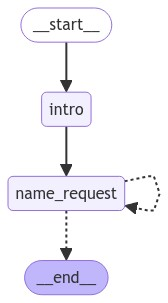

In [7]:
from IPython.display import Image, display
display(Image(app.get_graph(xray=True).draw_mermaid_png()))

# Making it more conversational
The requests are hard coded. In this modification I'll keep track of all the dialogue between the system, and all the decisions, and use that to inform the language model of how to communicate with the user.

In [9]:
from typing import TypedDict
from langgraph.graph import StateGraph, START, END
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate

# Defining state
class GraphState(TypedDict):
    first_name: str
    last_name: str
    incrementor: int
    conversation: list[tuple[str]]

workflow = StateGraph(GraphState)

# ===========================
class Name(TypedDict):
    first_name: str
    last_name: str

name_parse_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            """Parse the first and last name from the users message""",
        ),
        ("placeholder", "{messages}"),
    ]
)

name_parser = name_parse_prompt | ChatOpenAI(
    model="gpt-4o", temperature=0
).with_structured_output(Name)

def handle_name_request(state):
    state['incrementor'] += 1

    #if the conversation has just started, append a system prompt
    if state['conversation'] is None:
        system_prompt = '''
        You are an AI agent tasked with doing lead qualification for a real-estate
        company. Your present objective is to introduce yourself as "Rachael", say
        you're excited to help them get set up with a new home. After you introduce yourself,
        ask them for their name in full so you can get started.
        '''
        state['conversation'] = [('system', system_prompt)]


    chat = ChatOpenAI(model="gpt-4o", temperature=0)
    ai_request_to_user = chat.invoke(state['conversation']).content

    user_reponse = input(ai_request_to_user +'\n')
    state['conversation'].append(('user', user_reponse))
    name = name_parser.invoke({"messages": state['conversation']})
    state['first_name'] = name.get('first_name', '')
    state['last_name'] = name.get('last_name', '')
    return state

workflow.add_node("name_request", handle_name_request)
# ===========================
class IsAcceptable(TypedDict):
    is_acceptable: bool

name_check_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            """Is the name a full and complete first and last name? The name should either
be an obvious full legal name, or the user should have confirmed that it is their full name.
If either are true, then the name is considered acceptable.""",
        ),
        ("placeholder", "{messages}"),
    ]
)

name_checker = name_check_prompt | ChatOpenAI(
    model="gpt-4o", temperature=0
).with_structured_output(IsAcceptable)

def check_full_name(state):
    state['incrementor'] += 1

    name_check = name_checker.invoke({"messages": state['conversation']+[("user", f"first name: \"{state['first_name']}\", last name: \"{state['last_name']}\"")]})
    if name_check['is_acceptable']:
        return '__end__'
    else:
        system_prompt = '''
        The provided name appears to be incomplete. Please notify the user
that the name does not appear to be complete and request that they either
provide their full name or confirm that that is indeed their full name. You don't need to re-introduce yourself anymore.
        '''
        state['conversation'].append(('system', system_prompt))
        return 'name_request'
# ===========================

# Set entry point and edge
workflow.set_entry_point('name_request')
workflow.add_conditional_edges(
    'name_request',
    check_full_name,
    ["name_request", "__end__"]
)

# Compile and run the workflow
app = workflow.compile()
inputs = {"incrementor": 0, "conversation":None}  # Provide the initial state
result = app.invoke(inputs)
print('output state:')
print(result)

Hi there! I'm Rachael, and I'm excited to help you get set up with a new home. Could you please provide me with your full name so we can get started?
Hi Rachael! I'm looking to buy a new home!
Hi there! I'm excited to help you get set up with a new home. Could you please provide your full name so we can get started?
Yeah it's dan
Hi Dan! Could you please provide your full name so I can get started with helping you find your new home?
oh yeah dan w
Hi Dan! Could you please provide your full name so we can get started?
oh you need my full legal name. Why didn't you say so! daniel warfield
output state:
{'first_name': 'Daniel', 'last_name': 'Warfield', 'incrementor': 4, 'conversation': [('system', '\n        You are an AI agent tasked with doing lead qualification for a real-estate\n        company. Your present objective is to introduce yourself as "Rachael", say\n        you\'re excited to help them get set up with a new home. After you introduce yourself,\n        ask them for their na

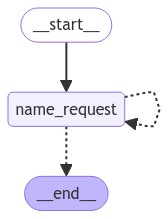

In [10]:
from IPython.display import Image, display
display(Image(app.get_graph(xray=True).draw_mermaid_png()))

# Fleshing out some more stuff
Imagining that they need to create an account with an email, then need to provide a short code from that email. First we need to ask them if they have an email. If we do we send them to make one and tell them to come back when they're done.

once they enter in some email, we "send a code" to that email, weather it exists or not. They then respond with that code and progress, or they have an invalid email. If their email is invalid we ask them to re-enter it.

In [12]:
from typing import TypedDict
from langgraph.graph import StateGraph, START, END
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate

# Defining state
class GraphState(TypedDict):
    first_name: str
    last_name: str
    incrementor: int
    conversation: list[tuple[str]]
    has_account: bool
    email: str
    verification_code: int

workflow = StateGraph(GraphState)

# ===========================
class Name(TypedDict):
    first_name: str
    last_name: str

name_parse_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            """Parse the first and last name from the users message""",
        ),
        ("placeholder", "{messages}"),
    ]
)

name_parser = name_parse_prompt | ChatOpenAI(
    model="gpt-4o", temperature=0
).with_structured_output(Name)

def handle_name_request(state):
    state['incrementor'] += 1

    #if the conversation has just started, append a system prompt
    if state['conversation'] is None:
        system_prompt = '''
        You are an AI agent tasked with doing lead qualification for a real-estate
        company. Your present objective is to introduce yourself as "Rachael", say
        you're excited to help them get set up with a new home. After you introduce yourself,
        ask them for their name in full so you can get started.
        '''
        state['conversation'] = [('system', system_prompt)]

    chat = ChatOpenAI(model="gpt-4o", temperature=0)
    ai_request_to_user = chat.invoke(state['conversation']).content

    user_reponse = input(ai_request_to_user +'\n')
    state['conversation'].append(('user', user_reponse))
    name = name_parser.invoke({"messages": state['conversation']})
    state['first_name'] = name['first_name']
    state['last_name'] = name['last_name']
    return state

workflow.add_node("name_request", handle_name_request)
# ===========================
class IsAcceptable(TypedDict):
    is_acceptable: bool

name_check_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            """Is the name a full and complete first and last name? The name should either
be an obvious full legal name, or the user should have confirmed that it is their full name.
If either are true, then the name is considered acceptable.""",
        ),
        ("placeholder", "{messages}"),
    ]
)

name_checker = name_check_prompt | ChatOpenAI(
    model="gpt-4o", temperature=0
).with_structured_output(IsAcceptable)

def check_full_name(state):
    state['incrementor'] += 1

    name_check = name_checker.invoke({"messages": state['conversation']+[("user", f"first name: \"{state['first_name']}\", last name: \"{state['last_name']}\"")]})
    if name_check['is_acceptable']:
        return 'has_account_node'
    else:
        system_prompt = '''
        The provided name appears to be incomplete. Please notify the user
that the name does not appear to be complete and request that they either
provide their full name or confirm that that is indeed their full name. You don't need to re-introduce yourself.
        '''
        state['conversation'].append(('system', system_prompt))
        return 'name_request'

# ===========================
class HasAccount(TypedDict):
    has_account: bool

has_account_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            """Does the user have an account or not?""",
        ),
        ("placeholder", "{messages}"),
    ]
)

has_account_parser = has_account_prompt | ChatOpenAI(
    model="gpt-4o", temperature=0
).with_structured_output(HasAccount)

def handle_has_account(state):
    state['incrementor'] += 1

    system_prompt = '''
    The users name has been acquired. Now, ask if they have an account
    already set up.
    '''
    state['conversation'].append(('system', system_prompt))

    chat = ChatOpenAI(model="gpt-4o", temperature=0)
    ai_request_to_user = chat.invoke(state['conversation']).content

    user_reponse = input(ai_request_to_user +'\n')
    state['conversation'].append(('user', user_reponse))
    has_account = has_account_parser.invoke({"messages": state['conversation']})
    state['has_account'] = has_account['has_account']
    return state

workflow.add_node("has_account_node", handle_has_account)

# ===========================
def check_has_account(state):
    state['incrementor'] += 1

    if state['has_account']:
        return 'get_email'
    else:
        system_prompt = '''
        The user does not have an account set up. Tell them to set one up at
        danielwarfield.dev then ask them to come back when they're done.
        Respond directly to the previous users message as if in a continuous
        conversation
        '''
        state['conversation'].append(('system', system_prompt))
        chat = ChatOpenAI(model="gpt-4o", temperature=0)
        ai_request_to_user = chat.invoke(state['conversation']).content
        user_reponse = input(ai_request_to_user +'\n')
        state['conversation'].append(('user', user_reponse))
        return 'get_email'

# ===========================
class Email(TypedDict):
    email: str

email_parse_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            """What email did the user provide?""",
        ),
        ("placeholder", "{messages}"),
    ]
)

email_parser = email_parse_prompt | ChatOpenAI(
    model="gpt-4o", temperature=0
).with_structured_output(Email)

def handle_request_email(state):
    state['incrementor'] += 1

    system_prompt = '''
    The user has an email associated to their account. Ask them for it.
    '''
    state['conversation'].append(('system', system_prompt))

    chat = ChatOpenAI(model="gpt-4o", temperature=0)
    ai_request_to_user = chat.invoke(state['conversation']).content

    user_reponse = input(ai_request_to_user +'\n')
    state['conversation'].append(('user', user_reponse))
    email = email_parser.invoke({"messages": state['conversation']})
    state['email'] = email['email']
    return state

workflow.add_node("get_email", handle_request_email)

# ===========================
class ShortCode(TypedDict):
    short_code: int

code_parse_ptompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            """Parse out the short integer code from the prompt""",
        ),
        ("placeholder", "{messages}"),
    ]
)

short_code_parser = code_parse_ptompt | ChatOpenAI(
    model="gpt-4o", temperature=0
).with_structured_output(ShortCode)

def email_verify(state):
    state['incrementor'] += 1

    system_prompt = '''
    Inform the user that a short code has been sent to their email. Ask them
    to confirm their email with that code.
    '''
    state['conversation'].append(('system', system_prompt))

    chat = ChatOpenAI(model="gpt-4o", temperature=0)
    ai_request_to_user = chat.invoke(state['conversation']).content

    user_reponse = input(ai_request_to_user +'\n')
    state['conversation'].append(('user', user_reponse))
    short_code = short_code_parser.invoke({"messages": state['conversation']})
    state['verification_code'] = short_code['short_code']

    return state

workflow.add_node("email_verify", email_verify)
# ===========================
def check_auth(state):
    state['incrementor'] += 1

    if state['email'] == 'hire@danielwarfield.dev' and state['verification_code'] == 1111:
        print('Email verified. Done!')
        return '__end__'
    else:
        system_prompt = '''
        Either the user name or short code was incorrect. Ask for the email again.
        '''
        state['conversation'].append(('system', system_prompt))
        chat = ChatOpenAI(model="gpt-4o", temperature=0)
        ai_request_to_user = chat.invoke(state['conversation']).content
        user_reponse = input(ai_request_to_user +'\n')
        state['conversation'].append(('user', user_reponse))
        return 'get_email'
# ===========================

# Set entry point and edges
workflow.set_entry_point('name_request')
workflow.add_conditional_edges(
    'name_request',
    check_full_name,
    ["name_request", "has_account_node"]
)
workflow.add_conditional_edges(
    'has_account_node',
    check_has_account,
    ["get_email"]
)
workflow.add_edge("get_email", "email_verify")
workflow.add_conditional_edges(
    'email_verify',
    check_auth,
    ["get_email", '__end__']
)

# Compile and run the workflow
app = workflow.compile()
inputs = {"incrementor": 0, "conversation":None}  # Provide the initial state
result = app.invoke(inputs)
print('output state:')
print(result)

Hi there! I'm Rachael, and I'm excited to help you get set up with a new home. Could you please provide me with your full name so we can get started?
dan w
Hi Dan, it looks like your name might be incomplete. Could you please provide your full name or confirm if "Dan W" is indeed your full name? This will help me get started on finding the perfect home for you.
yeah beleive it or not that's actually my full name. Weird parents.
Nice to meet you, Dan W! Do you already have an account set up with us?
yep
Great, Dan! Could you please provide the email address associated with your account?
yeah it's hire@danielwarfield.dev
Great, Dan! A short code has been sent to your email. Could you please check your inbox and provide me with that code to confirm your email?
just got it. 1111
Email verified. Done!
output state:
{'first_name': 'Dan', 'last_name': 'W', 'incrementor': 5, 'conversation': [('system', '\n        You are an AI agent tasked with doing lead qualification for a real-estate\n     

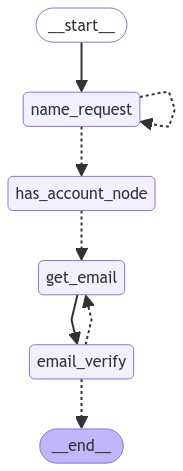

In [14]:
from IPython.display import Image, display
display(Image(app.get_graph(xray=True).draw_mermaid_png()))